# Import Library

In [1]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

Kode diatas berisi library-library yang diperlukan untuk membuat program klasifikasi citra yaitu:
1. Pengolahan Citra dan Visualisasi <br>
Library-library yang digunakan untuk pengolahan citra dan visualisasi yaitu:
    - `os` membantu dalam mengakses dan mengelola file gambar dari direktori tertentu. <br>
    - `cv2` (OpenCV) merupakan library inti untuk pemrosesan citra, seperti membaca gambar, mengubahnya ke skala abu-abu (grayscale), atau menerapkan filter seperti blur dan thresholding. <br>
    - `matplotlib.pyplot` digunakan untuk menampilkan gambar, grafik akurasi, atau visualisasi data lainnya. <br>
    - `numpy` berperan dalam manipulasi array, misalnya mengubah bentuk (reshape) data piksel atau melakukan normalisasi. <br>
    - `seaborn` membantu dalam membuat visualisasi statistik yang lebih menarik, seperti confusion matrix atau plot distribusi fitur.

2. Ekstraksi Fitur Tekstur (GLCM & Statistik) <br>
Untuk mengklasifikasikan citra berdasarkan tekstur, program ini menggunakan metode Gray-Level Co-occurrence Matrix (GLCM). `graycomatrix` dari `skimage.feature` menghitung matriks kemunculan tingkat keabuan, sementara `graycoprops` mengekstrak properti statistik seperti contrast, correlation, energy, dan homogeneity. Selain itu, `scipy.stats.entropy` digunakan untuk mengukur ketidakaturan tekstur, yang dapat menjadi fitur tambahan dalam klasifikasi.

3. Pembagian Dataset & Evaluasi Model <br>
Data yang telah diekstrak fiturnya disimpan dalam struktur tabel menggunakan `pandas`, memudahkan pengelolaan sebelum diproses oleh model. `train_test_split` dari `sklearn.model_selection` membagi data menjadi subset training dan testing untuk memastikan model dapat diuji secara independen. `cross_val_predict` digunakan untuk validasi silang guna meminimalkan overfitting dan mengevaluasi stabilitas model.

4. Model Klasifikasi <br>
Lalu pada program ini juga menerapkan beberapa algoritma machine learning untuk klasifikasi citra.  `RandomForestClassifier`   dipilih karena kemampuannya menangani data kompleks dengan banyak fitur. `SVC` (Support Vector Classifier) berguna untuk data berdimensi tinggi dengan pemisahan margin optimal. `KNeighborsClassifier` (KNN) adalah metode berbasis jarak yang sederhana tetapi memerlukan normalisasi data agar performanya optimal.

5. Metrik Evaluasi <br>
Untuk mengukur kinerja model, digunakan berbagai metrik evaluasi. `accuracy_score` menghitung persentase prediksi benar, sementara `precision_score`, `recall_score`, dan `f1_score` memberikan insight lebih mendalam tentang performa model pada tiap kelas. `confusion_matrix` dan `ConfusionMatrixDisplay` menampilkan jumlah prediksi benar dan salah secara visual, sedangkan `classification_report` merangkum seluruh metrik dalam bentuk tabel.

# Data Loading

In [2]:
data = []
labels = []
file_name = []
target_size = (256, 256)
for sub_folder in os.listdir("Dataset"):
    sub_folder_files = os.listdir(os.path.join("Dataset", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("Dataset", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.resize(img, target_size)

        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)



<p align="justify">Kode di atas bertujuan untuk memuat, memproses, dan menyiapkan data citra dari direktori "Dataset" untuk keperluan klasifikasi. Program ini pertama-tama membaca setiap subfolder dalam direktori "Dataset", kemudian mengiterasi setiap file gambar di dalamnya. Setiap gambar dibaca menggunakan OpenCV (cv.imread), dikonversi ke tipe data uint8, diubah menjadi grayscale (cv.COLOR_BGR2GRAY), dan diresize ke ukuran yang seragam (256x256 piksel) untuk memastikan konsistensi dimensi. Gambar yang telah diproses disimpan dalam list data, sementara label kelasnya (nama subfolder) disimpan dalam list labels, dan nama file asli disimpan dalam file_name. Akhirnya, list data dan labels diubah menjadi array NumPy (np.array) untuk memudahkan pemrosesan lebih lanjut dalam pipeline machine learning, seperti ekstraksi fitur atau pelatihan model. Kode ini merupakan tahap awal dalam pipeline klasifikasi citra yang memastikan data dalam format yang siap digunakan untuk analisis lebih lanjut.</p>

# Data Understanding

<p align="justify">Kode tersebut digunakan untuk menampilkan distribusi jumlah data per kelas dalam bentuk diagram batang menggunakan matplotlib, di mana np.unique(labels, return_counts=True) menghitung jumlah sampel untuk setiap kelas unik yang ada dalam list labels, kemudian hasilnya divisualisasikan dengan plt.bar() yang menampilkan nama kelas pada sumbu x dan jumlah datanya pada sumbu y. Diagram ini diberi judul "Distribusi Jumlah Data per Kelas", label sumbu x ("Kelas") dan y ("Jumlah Data"), serta label kelas pada sumbu x diputar 45 derajat (plt.xticks(rotation=45)) agar lebih mudah dibaca jika nama kelas panjang, sehingga membantu pengguna memahami sebaran data apakah seimbang atau tidak sebelum melatih model klasifikasi.</p>

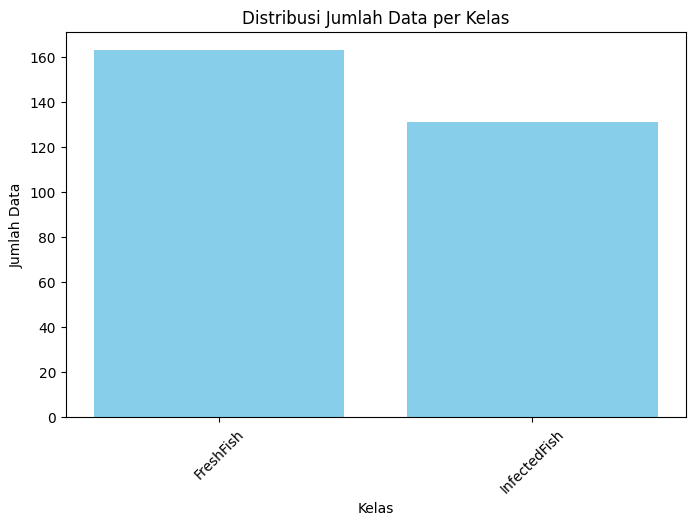

In [3]:
# Menampilkan jumlah data per kelas
unique_labels, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Jumlah Data per Kelas")
plt.xticks(rotation=45)
plt.show()

<p align="justify">Kode dibawah ini bertujuan untuk menganalisis dan membandingkan distribusi intensitas piksel antara citra ikan segar (FreshFish) dan ikan terinfeksi (InfectedFish) melalui visualisasi histogram. Pertama, data dipisahkan berdasarkan kelas menggunakan list comprehension, di mana fresh_fish_samples dan infected_fish_samples menyimpan citra-citra sesuai labelnya. Kemudian, untuk masing-masing kelas, 5 sampel citra acak (atau kurang jika data kurang dari 5) dipilih, dan histogram intensitas pikselnya diplot dengan plt.hist(). Fungsi ravel() mengubah citra 2D menjadi array 1D, sementara bins=256 menunjukkan rentang nilai piksel (0-255). Parameter alpha=0.5 membuat histogram semi-transparan agar overlap antar sampel terlihat jelas. Sumbu x (Intensitas Pixel) mewakili nilai piksel (0=hitam hingga 255=putih), sedangkan sumbu y (Frekuensi) menunjukkan jumlah kemunculan nilai tersebut. Judul dan legenda (label) ditambahkan untuk identifikasi, serta plt.show() menampilkan grafik. Visualisasi ini membantu mengidentifikasi pola perbedaan pencahayaan atau tekstur antara kedua kelas, misalnya apakah ikan terinfeksi cenderung lebih gelap atau memiliki distribusi piksel yang berbeda, yang dapat menjadi fitur penting dalam klasifikasi.</p>

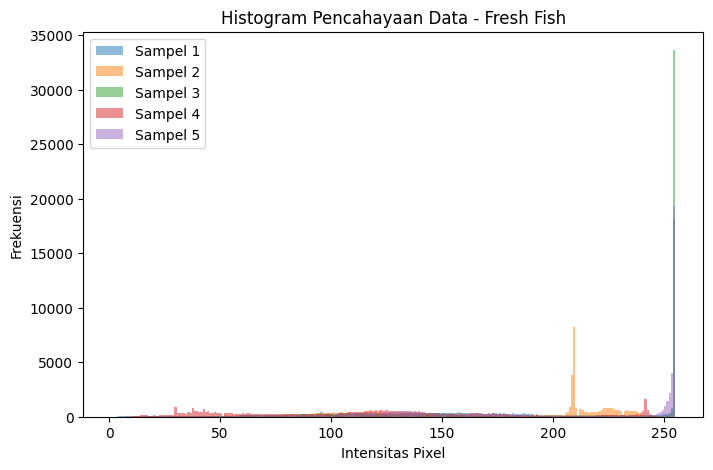

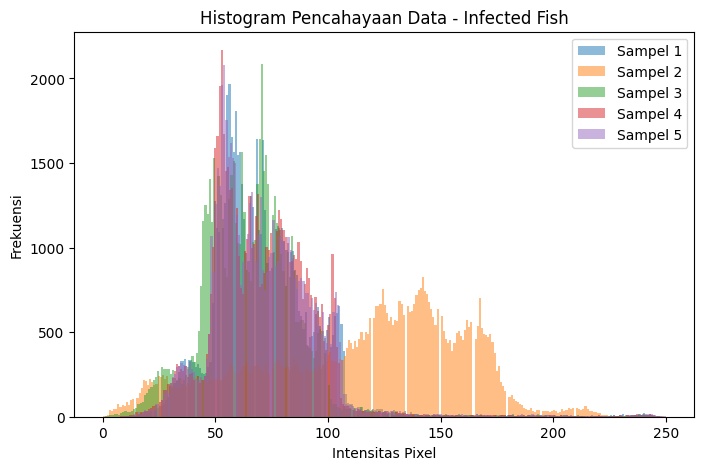

In [4]:
fresh_fish_samples = [data[i] for i in range(len(labels)) if labels[i] == "FreshFish"]
infected_fish_samples = [data[i] for i in range(len(labels)) if labels[i] == "InfectedFish"]

plt.figure(figsize=(8, 5))
for i in range(min(5, len(fresh_fish_samples))):
    img = fresh_fish_samples[i]
    plt.hist(img.ravel(), bins=256, alpha=0.5, label=f'Sampel {i+1}')
plt.xlabel("Intensitas Pixel")
plt.ylabel("Frekuensi")
plt.title("Histogram Pencahayaan Data - Fresh Fish")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(min(5, len(infected_fish_samples))):  
    img = infected_fish_samples[i]
    plt.hist(img.ravel(), bins=256, alpha=0.5, label=f'Sampel {i+1}')
plt.xlabel("Intensitas Pixel")
plt.ylabel("Frekuensi")
plt.title("Histogram Pencahayaan Data - Infected Fish")
plt.legend()
plt.show()

<p align="justify">Kode dibawah ini digunakan untuk menampilkan contoh visual dari citra ikan sehat (FreshFish) dan ikan terinfeksi (InfectedFish) dalam bentuk grid horizontal menggunakan matplotlib, di mana setiap grid menampilkan maksimal 5 sampel citra (atau lebih sedikit jika data tidak mencukupi) dengan ukuran figure 15x5 inci. Setiap citra ditampilkan dalam skala abu-abu (cmap="gray") menggunakan imshow(), diberi judul individual sesuai jenis dan urutan sampel (misal "Ikan Sehat 1"), serta dihilangkan sumbu koordinatnya (axis("off")) untuk fokus pada visualisasi gambar, sementara suptitle() memberikan judul utama di atas masing-masing kelompok gambar ("Sampel Ikan Sehat" dan "Sampel Ikan Terinfeksi") untuk memudahkan identifikasi perbedaan visual antara kedua kelas sebelum dilakukan analisis lebih lanjut.</p>

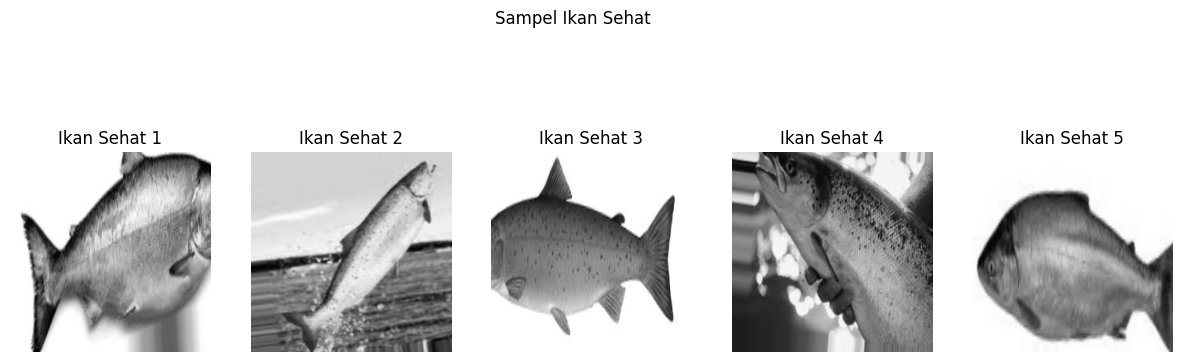

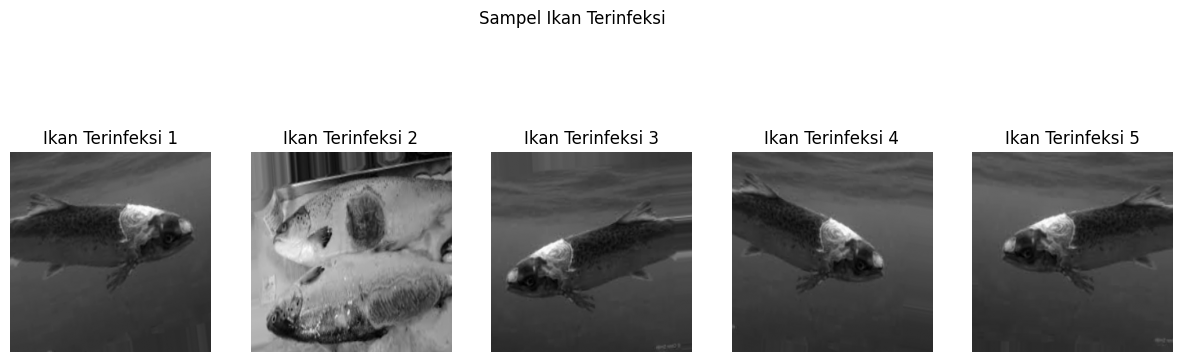

In [5]:
# Menampilkan sampel ikan sehat
fig, axes = plt.subplots(1, min(5, len(fresh_fish_samples)), figsize=(15, 5))
for i in range(min(5, len(fresh_fish_samples))):  # Menampilkan hingga 5 sampel
    axes[i].imshow(fresh_fish_samples[i], cmap="gray")
    axes[i].set_title(f"Ikan Sehat {i+1}")
    axes[i].axis("off")
plt.suptitle("Sampel Ikan Sehat")
plt.show()

fig, axes = plt.subplots(1, min(5, len(infected_fish_samples)), figsize=(15, 5))
for i in range(min(5, len(infected_fish_samples))):  # Menampilkan hingga 5 sampel
    axes[i].imshow(infected_fish_samples[i], cmap="gray")
    axes[i].set_title(f"Ikan Terinfeksi {i+1}")
    axes[i].axis("off")
plt.suptitle("Sampel Ikan Terinfeksi")
plt.show()

# Define Data Augmentation

<p align="justify">Kode dibawah ini digunakan untuk melakukan augmentasi data pada citra ikan untuk memperbanyak dataset dengan berbagai transformasi gambar, yang bertujuan meningkatkan variasi data dan mencegah overfitting saat pelatihan model machine learning. Prosesnya dimulai dengan membuat dictionary augmented untuk menyimpan tiga komponen: data citra hasil augmentasi, label kelas, dan nama file. Untuk setiap gambar asli dalam dataset (data[i]), dilakukan empat jenis transformasi: (1) flip horizontal menggunakan cv.flip(img, 1), (2) flip vertikal dengan cv.flip(img, 0), (3) rotasi 90 derajat searah jarum jam melalui cv.ROTATE_90_CLOCKWISE, dan (4) rotasi 180 derajat dengan cv.ROTATE_180. Setiap citra hasil transformasi disimpan beserta label aslinya dan nama file yang diberi suffix sesuai jenis augmentasi (contoh: filename_flip_h). Terakhir, kode menampilkan perbandingan jumlah data sebelum dan setelah augmentasi, dimana dataset akan bertambah menjadi 5 kali lipat (1 gambar asli + 4 hasil augmentasi) untuk setiap citra, sehingga memperkaya variasi data tanpa mengubah label kelas yang sesungguhnya.</p>

In [6]:
augmented = {
    'data': [],
    'labels': [],
    'filenames': []
}

# Proses augmentasi
for i in range(len(data)):
    img = data[i]
    label = labels[i]
    filename = file_name[i]

    # 1. Flip Horizontal
    img_flip_h = cv.flip(img, 1)

    # 2. Flip Vertikal
    img_flip_v = cv.flip(img, 0)

    # 3. Rotasi 90 Derajat
    img_rot_90 = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)

    # 4. Rotasi 180 Derajat
    img_rot_180 = cv.rotate(img, cv.ROTATE_180)

    # Simpan semua hasil ke dalam dictionary 'augmented'
    augmented_images = [
        (img_flip_h, 'flip_h'),
        (img_flip_v, 'flip_v'),
        (img_rot_90, 'rot_90'),
        (img_rot_180, 'rot_180'),
    ]

    for img_aug, suffix in augmented_images:
        augmented['data'].append(img_aug)
        augmented['labels'].append(label)
        augmented['filenames'].append(f"{filename}_{suffix}")

# Tampilkan hasil
print("Jumlah data sebelum augmentasi:", len(data))
print("Jumlah data setelah augmentasi:", len(augmented['data']))

Jumlah data sebelum augmentasi: 294
Jumlah data setelah augmentasi: 1176


<p align="justify">Kode di bawah bertujuan untuk memvisualisasikan hasil augmentasi data citra dengan menampilkan lima varian gambar (asli, flip horizontal, flip vertikal, rotasi 90°, dan rotasi 180°) dari setiap kelas ikan (sehat/terinfeksi) dalam bentuk grid horizontal. Untuk setiap label unik yang ditemukan dalam data augmentasi, kode mengambil satu sampel acak kemudian membuat empat transformasi berbeda menggunakan OpenCV (cv.flip dan cv.rotate), menampilkannya dalam satu baris subplot dengan matplotlib, dimana setiap gambar diberi judul sesuai jenis transformasi dan label kelasnya, diakhiri dengan judul utama yang menjelaskan kelas yang sedang ditampilkan. Visualisasi ini membantu mengevaluasi efektivitas augmentasi dengan membandingkan gambar asli dengan hasil transformasinya, memastikan ciri khas kelas tetap terjaga meskipun mengalami berbagai perubahan geometris, sekaligus memberikan pemahaman visual tentang variasi data yang dihasilkan dari proses augmentasi.</p>

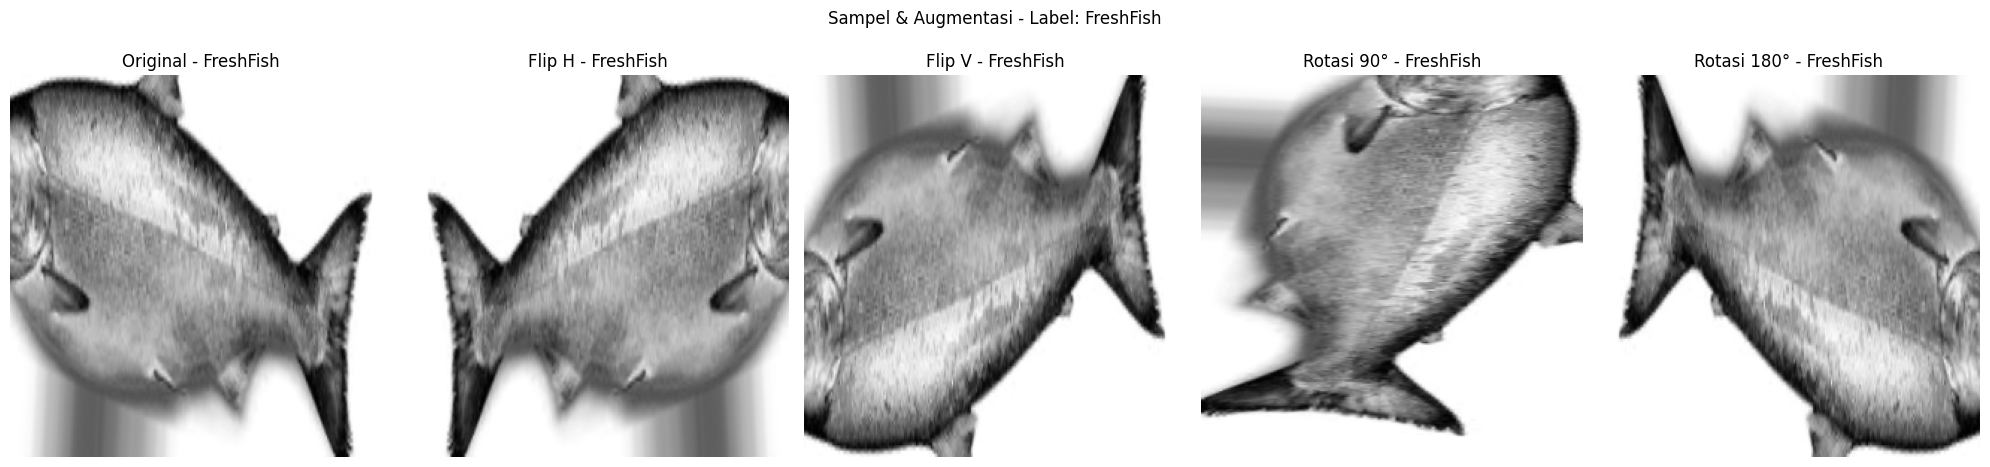

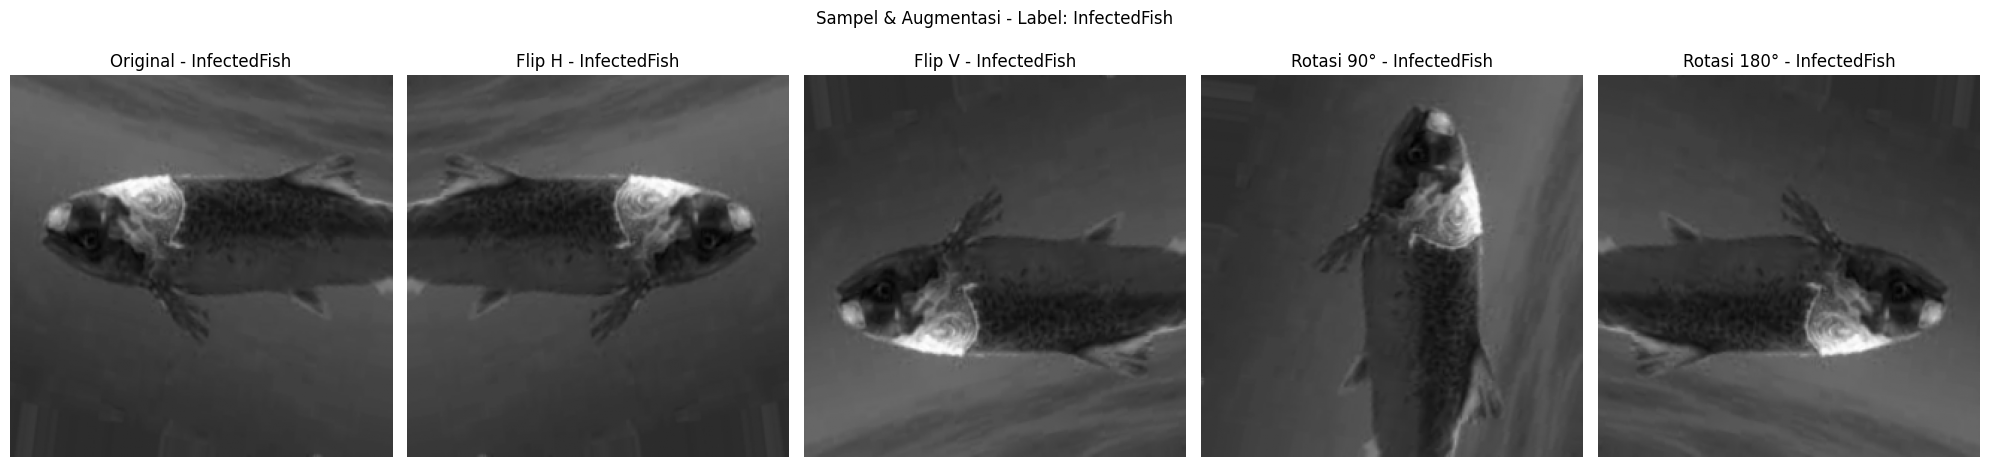

In [7]:
# Ambil label unik dari data yang telah di-augmentasi
unique_labels = np.unique(augmented['labels'])

for label in unique_labels:
    # Ambil semua gambar yang label-nya sama
    samples = [augmented['data'][i] for i in range(len(augmented['labels'])) if augmented['labels'][i] == label]

    if len(samples) > 0:
        sample_img = samples[0]  # Ambil satu contoh gambar

        # Siapkan tampilan
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        augment_titles = ["Original", "Flip H", "Flip V", "Rotasi 90°", "Rotasi 180°"]

        # Daftar gambar hasil augmentasi tanpa translasi
        augmentations = [
            sample_img,
            cv.flip(sample_img, 1),
            cv.flip(sample_img, 0),
            cv.rotate(sample_img, cv.ROTATE_90_CLOCKWISE),
            cv.rotate(sample_img, cv.ROTATE_180)
        ]

        # Tampilkan semua hasil dalam satu baris
        for i in range(5):
            axes[i].imshow(augmentations[i], cmap="gray")
            axes[i].set_title(f"{augment_titles[i]} - {label}")
            axes[i].axis("off")

        plt.suptitle(f"Sampel & Augmentasi - Label: {label}")
        plt.tight_layout()
        plt.show()


# Preprocessing

In [8]:
def normalize(img):
    img = img.astype(np.float32)
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val - min_val == 0:
        return np.zeros_like(img, dtype=np.uint8)
    norm_img = (img - min_val) / (max_val - min_val) * 255
    return norm_img.astype(np.uint8)

def histogram_equalization(img):
    # Histogram Equalization secara manual
    hist, bins = np.histogram(img.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf_masked = np.ma.masked_equal(cdf, 0)
    cdf_min = cdf_masked.min()
    cdf_max = cdf_masked.max()
    cdf_masked = (cdf_masked - cdf_min) * 255 / (cdf_max - cdf_min)
    cdf_final = np.ma.filled(cdf_masked, 0).astype('uint8')
    img_eq = cdf_final[img]
    return img_eq


<p align="justify">Kode di bawah berisi fungsi-fungsi dari preprocessing. Fungsi normalize() bertujuan untuk melakukan normalisasi citra dengan mengubah nilai piksel ke rentang 0-255 melalui transformasi linear, dimana pertama-tama citra dikonversi ke float32, kemudian nilai minimum dan maksimum dihitung untuk menentukan faktor skala, dengan penanganan khusus jika semua nilai piksel sama (menghasilkan citra hitam), sedangkan fungsi histogram_equalization() menerapkan equalisasi histogram secara manual untuk meningkatkan kontras citra dengan cara menghitung histogram, cumulative distribution function (CDF), kemudian melakukan transformasi CDF untuk meratakan distribusi intensitas piksel, dimana nilai CDF yang nol di-masking untuk menghindari pembagian dengan nol, dan hasil akhirnya memetakan kembali nilai piksel asli berdasarkan CDF yang telah dinormalisasi ke rentang 0-255, sehingga menghasilkan citra dengan kontras yang lebih baik.</p>

In [9]:
def prepro1(img):
    norm = normalize(img)
    eq = histogram_equalization(norm)
    return eq

<p align="justify">Kode di atas berisi tentang pengaplikasian fungsi-fungsi preprocessing yaang telah dibuat sebelumnya. Kode prepro1() berisi dua preprocessing yang telah dibuat yaitu normalize() yang menormalkan nilai piksel ke range 0-255, dan histogram_equalization() yang meningkatkan kontras dengan meratakan distribusi intensitas. Fungsi ini mengembalikan citra hasil equalisasi yang telah dinormalisasi.</p>

<p align="justify">Kode dibawah ini melakukan mengaplikasikan proses preprocessing dan memvisualisasikannya dengan dikategorikan sebagai "FreshFish" (ikan sehat) dan "InfectedFish" (ikan terinfeksi). Pertama, kode menginisialisasi list kosong dataPreprocessed_1 untuk menyimpan hasil preprocessing menggunakan fungsi prepro1 terhadap setiap gambar dalam augmented[data]. Kemudian, berdasarkan label yang sesuai di augmented[labels], gambar-gambar yang telah dipreproses tersebut diklasifikasikan ke dalam dua list yaitu dataPreprocessed_healthy dan dataPreprocessed_infected. Terakhir, kode menggunakan matplotlib untuk menampilkan 10 sampel gambar dari masing-masing kategori dalam satu grid berukuran 4x5, dengan 10 gambar pertama menunjukkan ikan sehat dan 10 gambar berikutnya menunjukkan ikan terinfeksi, semuanya dalam skala abu-abu (cmap='gray').</p>

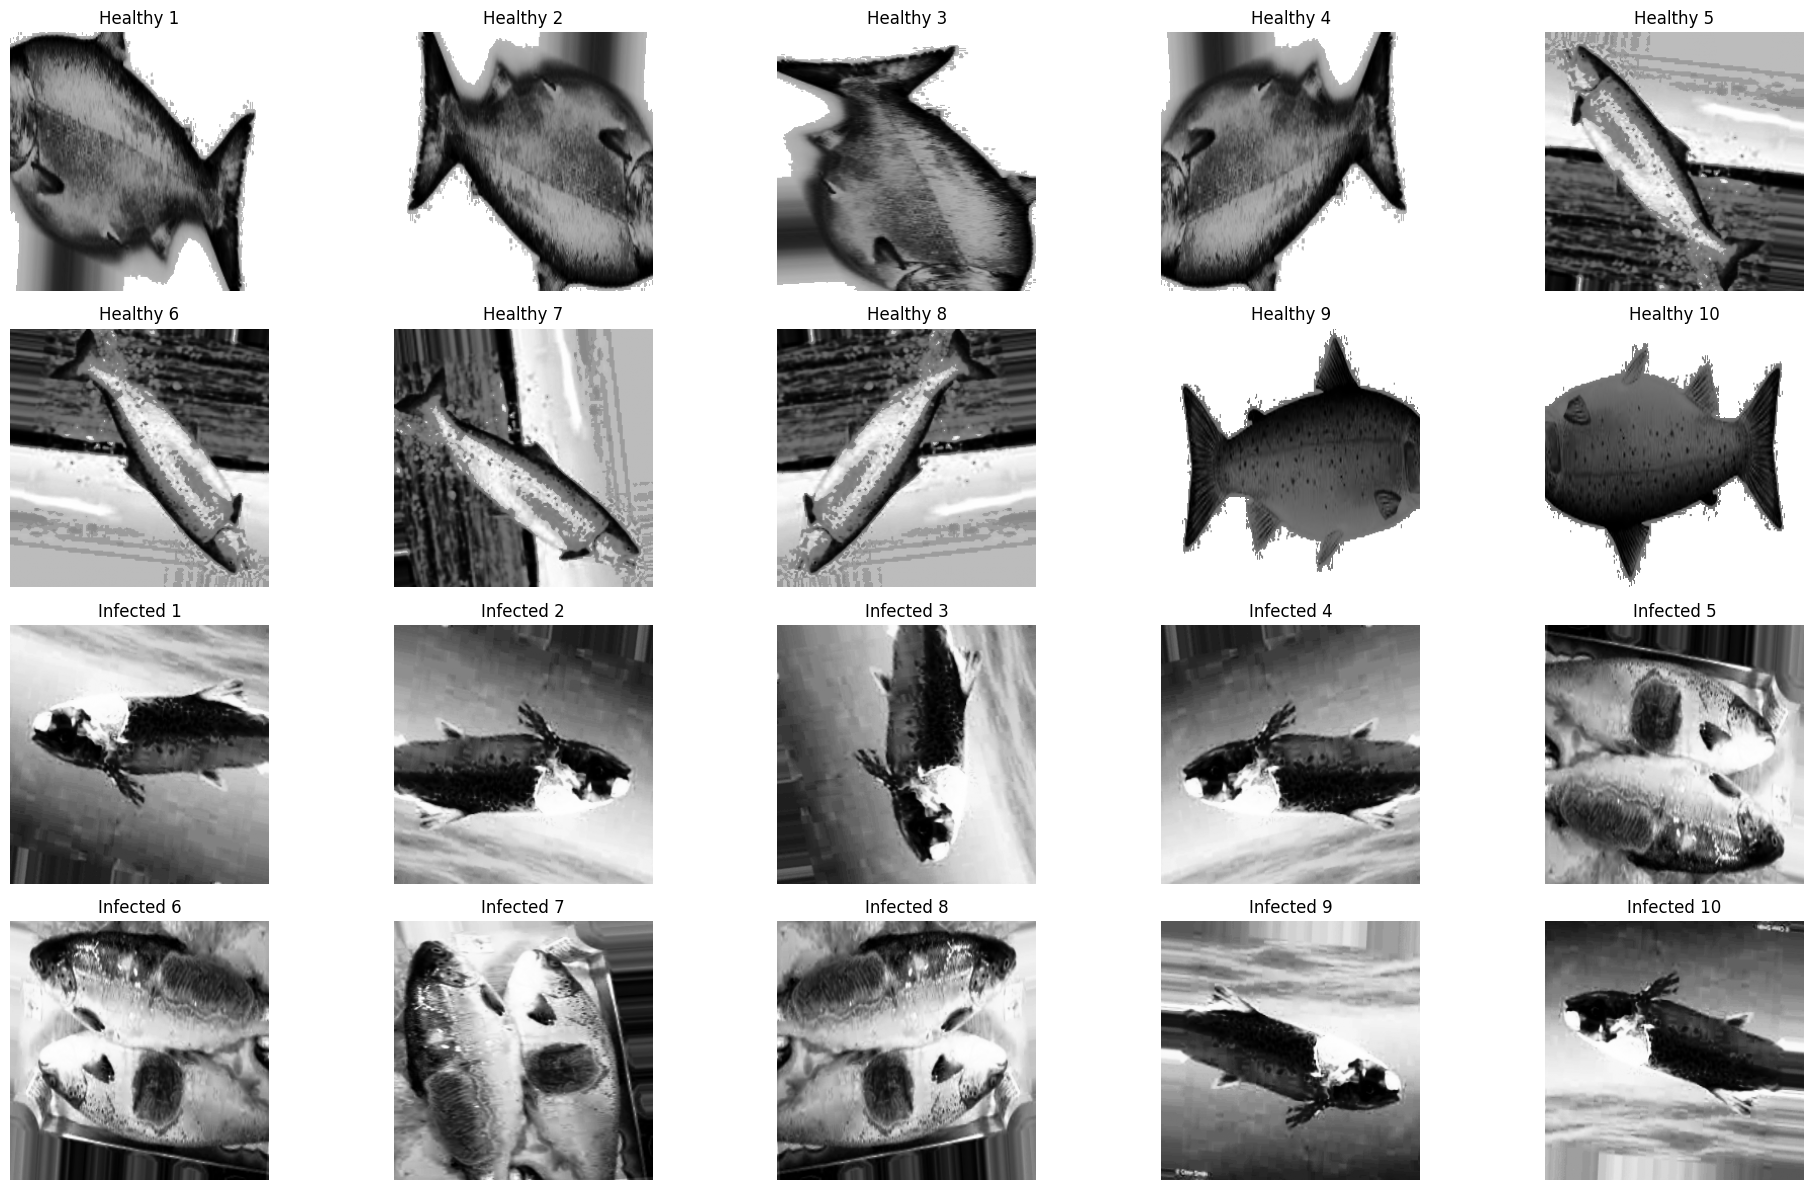

In [41]:
# Inisialisasi list untuk menyimpan hasil preprocessing
dataPreprocessed_1 = []

# Ambil data hasil augmentasi
augmented_data = augmented['data']

# Lakukan preprocessing untuk masing-masing percobaan
for img in augmented_data:
    dataPreprocessed_1.append(prepro1(img))
dataPreprocessed = dataPreprocessed_1

dataPreprocessed_healthy = []
dataPreprocessed_infected = []

labels = augmented['labels']

# Lakukan preprocessing untuk masing-masing percobaan
for img, label in zip(dataPreprocessed, labels):
    if label == "FreshFish":
        dataPreprocessed_healthy.append(img)
    elif label == "InfectedFish":
        dataPreprocessed_infected.append(img)

# Menampilkan 10 sampel gambar dari masing-masing kategori
fig, axes = plt.subplots(4, 5, figsize=(20, 12))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(dataPreprocessed_healthy[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Healthy {i+1}")

for i in range(10):
    axes[i+10].imshow(dataPreprocessed_infected[i], cmap='gray')
    axes[i+10].axis('off')
    axes[i+10].set_title(f"Infected {i+1}")

plt.tight_layout()
plt.show()

# Feature Extraction

In [11]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

<p align="justify">Kode diatas berisi fungsi glcm(image, derajat) yang digunakan untuk menghitung matriks Gray Level Co-occurrence Matrix (GLCM) dari sebuah citra grayscale berdasarkan sudut arah tertentu yang diberikan melalui parameter derajat. Fungsi ini pertama-tama mengonversi nilai derajat ke dalam radian sesuai standar sudut GLCM—0°, 45°, 90°, atau 135°—dan memberikan error jika sudut yang dimasukkan tidak valid. Kemudian, fungsi memanggil graycomatrix dari library skimage.feature untuk menghitung GLCM dengan jarak piksel 1, menggunakan nilai intensitas hingga 256 tingkat abu-abu, dan mengaktifkan opsi simetri serta normalisasi.</p>

In [12]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

<p align="justify">Kode diatas berisi fungsi correlation(matriks) yang bertujuan untuk menghitung nilai korelasi tekstur dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) dengan memanfaatkan fungsi graycoprops dari pustaka skimage.feature, di mana parameter correlation digunakan untuk mengekstrak properti korelasi yang mengukur sejauh mana piksel dalam citra memiliki hubungan linier satu sama lain berdasarkan intensitasnya; fungsi ini kemudian mengakses elemen pertama dari hasil yang dikembalikan oleh graycoprops (indeks [0, 0]) untuk mendapatkan nilai korelasi tunggal yang merepresentasikan tingkat keterkaitan antar piksel pada arah dan jarak yang telah ditentukan sebelumnya dalam matriks GLCM, sehingga nilai tersebut dapat digunakan sebagai salah satu fitur penting dalam analisis tekstur dan klasifikasi citra.</p>

In [13]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

<p align="justify">Kode diatas berisi fungsi dissimilarity(matriks) yang digunakan untuk menghitung nilai ketidaksamaan (dissimilarity) tekstur dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) dengan memanfaatkan fungsi graycoprops dari pustaka skimage.feature, di mana parameter dissimilarity secara spesifik mengambil ukuran yang mencerminkan seberapa besar perbedaan intensitas antara pasangan piksel tetangga dalam citra; fungsi ini kemudian mengakses elemen pertama hasil yang dikembalikan ([0, 0]) untuk memperoleh nilai tunggal ketidaksamaan yang menggambarkan tingkat variasi atau kontras lokal pada gambar berdasarkan hubungan spasial antar piksel, yang sangat berguna dalam proses ekstraksi fitur tekstur guna membedakan pola dan struktur dalam analisis citra dan klasifikasi.</p>

In [14]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

<p align="justify">Kode diatas berisi fungsi homogenity(matriks) yang bertujuan untuk menghitung nilai homogenitas tekstur dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) dengan menggunakan fungsi graycoprops dari pustaka skimage.feature, di mana parameter homogeneity mengukur seberapa seragam atau serapi nilai intensitas piksel dalam citra berdasarkan hubungan spasialnya; fungsi ini kemudian mengambil elemen pertama dari hasil yang dikembalikan ([0, 0]) untuk mendapatkan satu nilai homogenitas tunggal yang menunjukkan tingkat keseragaman tekstur—nilai yang tinggi mengindikasikan bahwa piksel-piksel memiliki intensitas yang serupa dan tersebar merata, sehingga fitur ini sangat berguna dalam membedakan area dengan tekstur halus dari area yang kasar dalam analisis citra dan klasifikasi.</p>

In [15]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

<p align="justify">Kode ditas berisi fungsi contrast(matriks) yang digunakan untuk menghitung nilai kontras tekstur dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) dengan memanfaatkan fungsi graycoprops dari pustaka skimage.feature, di mana parameter contrast secara spesifik mengukur perbedaan intensitas antara piksel-piksel yang berdekatan dalam citra, sehingga mencerminkan tingkat variasi atau perubahan lokal pada tekstur gambar; fungsi ini kemudian mengambil nilai pada indeks [0, 0] dari hasil keluaran graycoprops untuk memperoleh satu angka kontras tunggal yang menunjukkan seberapa tajam atau kasar tekstur dalam citra tersebut, yang sangat berguna dalam ekstraksi fitur untuk keperluan analisis citra dan klasifikasi pola.</p>

In [16]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

<p align="justify">Kode diatas berisi fungsi ASM(matriks) ini berfungsi untuk menghitung nilai Angular Second Moment (ASM), yang juga dikenal sebagai energi tekstur, dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) dengan menggunakan fungsi graycoprops dari pustaka skimage.feature, di mana parameter ASM mengukur tingkat keteraturan dan konsistensi tekstur dalam citra dengan menghitung jumlah kuadrat elemen-elemen pada matriks GLCM; fungsi ini kemudian mengambil elemen pertama hasil keluaran ([0, 0]) untuk mendapatkan satu nilai tunggal ASM yang mencerminkan seberapa seragam dan teratur pola intensitas piksel pada citra, sehingga nilai ini sangat berguna sebagai fitur tekstur yang menunjukkan kepadatan dan kestabilan pola untuk keperluan analisis dan klasifikasi citra.</p>

In [17]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

<p align="justify">Kode diatas berisi fungsi energy(matriks) ini digunakan untuk menghitung nilai energi tekstur dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) dengan memanfaatkan fungsi graycoprops dari pustaka skimage.feature, di mana parameter energy mengukur intensitas atau kekuatan pola tekstur dengan menghitung akar kuadrat dari Angular Second Moment (ASM), sehingga memberikan indikasi tentang keteraturan dan konsistensi distribusi piksel dalam citra; fungsi ini kemudian mengambil elemen pertama hasil keluaran ([0, 0]) untuk mendapatkan satu nilai energi tunggal yang menunjukkan sejauh mana tekstur dalam gambar bersifat homogen dan terstruktur, yang sangat berguna dalam ekstraksi fitur untuk analisis dan klasifikasi citra berbasis tekstur.</p>

In [18]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

<p align="justify">Kode diatas berisi fungsi entropyGlcm(matriks) ini digunakan untuk menghitung nilai entropi dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) dengan cara memanfaatkan fungsi entropy dari pustaka scipy.stats, di mana matriks GLCM tersebut terlebih dahulu diubah menjadi sebuah array satu dimensi (dengan metode .ravel()) agar dapat dihitung distribusi probabilitasnya; entropi ini mengukur tingkat ketidakteraturan atau kompleksitas tekstur dalam citra, di mana nilai entropi yang lebih tinggi menunjukkan pola tekstur yang lebih acak dan tidak teratur, sedangkan nilai yang lebih rendah mengindikasikan pola yang lebih terstruktur dan homogen; oleh karena itu, nilai entropi dari GLCM ini sangat berguna sebagai fitur statistik dalam analisis tekstur untuk membedakan karakteristik visual dari citra yang berbeda.</p>

In [19]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Dalam proses ekstraksi fitur tekstur, kode ini melakukan perhitungan matriks Gray Level Co-occurrence Matrix (GLCM) untuk setiap citra hasil preprocessing pada empat arah sudut berbeda yaitu 0°, 45°, 90°, dan 135°, di mana untuk setiap citra yang ada dalam daftar `dataPreprocessed`, fungsi glcm dipanggil secara berurutan dengan parameter sudut yang sesuai untuk menghasilkan empat matriks GLCM yang merepresentasikan hubungan spasial piksel berdasarkan arah tersebut; kemudian, setiap matriks hasil perhitungan disimpan secara terpisah ke dalam daftar yang berbeda-beda sesuai sudutnya, yakni Derajat0, Derajat45, Derajat90, dan Derajat135, sehingga memungkinkan analisis tekstur yang lebih komprehensif dan detail dengan mempertimbangkan variasi orientasi pola tekstur dalam citra, yang nantinya dapat digunakan untuk ekstraksi fitur statistik guna meningkatkan performa klasifikasi citra berbasis tekstur.

In [20]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

Kode diatas ini menginisialisasi sejumlah list kosong yang akan digunakan untuk menyimpan nilai-nilai fitur tekstur yang diekstrak dari matriks GLCM pada empat sudut berbeda yaitu 0°, 45°, 90°, dan 135°, di mana setiap fitur tekstur seperti kontras, dissimilaritas, homogenitas, entropi, Angular Second Moment (ASM), energi, dan korelasi memiliki empat list terpisah sesuai dengan sudut pengambilan matriks GLCM-nya; inisialisasi ini bertujuan untuk memudahkan pengorganisasian dan pengelompokan hasil ekstraksi fitur sehingga setiap jenis fitur dapat dianalisis secara spesifik berdasarkan arah sudutnya, memungkinkan evaluasi yang lebih detail dan menyeluruh terhadap karakteristik tekstur dalam citra, yang nantinya akan digunakan untuk keperluan analisis lebih lanjut, seperti pelatihan dan pengujian model klasifikasi.

In [21]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Dalam kode diatas ini, dilakukan perhitungan nilai korelasi tekstur untuk setiap citra yang telah melalui preprocessing dengan menggunakan matriks GLCM pada empat sudut berbeda, yaitu 0°, 45°, 90°, dan 135°, di mana pada setiap iterasi loop yang berjalan sebanyak jumlah citra dalam dataPreprocessed, fungsi correlation dipanggil untuk mengambil nilai korelasi dari masing-masing matriks GLCM yang disimpan dalam daftar Derajat0, Derajat45, Derajat90, dan Derajat135; hasil nilai korelasi ini kemudian disimpan secara berurutan ke dalam list khusus sesuai sudutnya, yaitu correlation0, correlation45, correlation90, dan correlation135, sehingga data ini dapat digunakan untuk analisis lebih lanjut yang bertujuan memahami hubungan spasial antar piksel dalam berbagai orientasi tekstur citra.

In [22]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode diatas ini melakukan perhitungan nilai kontras tekstur dari setiap citra yang sudah melalui tahap preprocessing dengan menggunakan matriks GLCM pada empat sudut berbeda, yaitu 0°, 45°, 90°, dan 135°, di mana pada setiap iterasi loop sebanyak jumlah citra dalam dataPreprocessed, fungsi contrast dipanggil secara berurutan untuk mendapatkan nilai kontras dari matriks GLCM yang tersimpan pada list Derajat0, Derajat45, Derajat90, dan Derajat135; nilai kontras yang dihasilkan kemudian dimasukkan ke dalam list khusus sesuai sudutnya, yakni Kontras0, Kontras45, Kontras90, dan Kontras135, sehingga memudahkan analisis tekstur berdasarkan orientasi sudut yang berbeda untuk setiap citra yang dianalisis.

In [23]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Pada bagian kode diatas ini, dilakukan proses perhitungan nilai dissimilarity (ketidaksamaan) dari data citra yang telah diproses sebelumnya. Untuk setiap elemen dalam kumpulan data yang telah dipreproses (dataPreprocessed), program akan menghitung nilai dissimilarity dari derajat arah tekstur citra, yaitu pada sudut 0°, 45°, 90°, dan 135°. Nilai tersebut dihitung dengan memanggil fungsi dissimilarity() pada masing-masing derajat—misalnya Derajat0[i] untuk sudut 0°, Derajat45[i] untuk 45°, dan seterusnya. Hasil dari setiap perhitungan kemudian disimpan ke dalam list yang sesuai, yaitu dissimilarity0, dissimilarity45, dissimilarity90, dan dissimilarity135. Proses ini penting karena nilai dissimilarity menjadi salah satu ciri atau fitur tekstur yang akan digunakan dalam tahap analisis atau klasifikasi, misalnya dalam pengenalan pola atau klasifikasi citra berdasarkan karakteristik arah teksturnya.

In [24]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

<p align="justify">Pada bagian kode diatas ini, dilakukan proses perhitungan nilai homogeneity (keseragaman) dari tekstur citra berdasarkan arah tertentu. Untuk setiap data dalam dataPreprocessed, sistem akan menghitung nilai homogeneity pada empat arah utama, yaitu 0°, 45°, 90°, dan 135°. Perhitungan ini dilakukan dengan memanggil fungsi homogenity() terhadap masing-masing matriks derajat keabuan hasil ekstraksi GLCM (Gray Level Co-occurrence Matrix) pada tiap sudut—seperti Derajat0[i] untuk arah 0°, Derajat45[i] untuk 45°, dan seterusnya. Nilai yang dihasilkan dari fungsi tersebut mencerminkan seberapa seragam distribusi nilai piksel dalam citra pada arah tertentu, di mana semakin tinggi nilai homogeneity, maka semakin sedikit variasi teksturnya. Setiap nilai hasil perhitungan kemudian disimpan ke dalam list yang sesuai (homogenity0, homogenity45, homogenity90, dan homogenity135) untuk dianalisis lebih lanjut. Nilai-nilai ini nantinya sangat berguna sebagai fitur dalam proses klasifikasi citra atau pengenalan pola berdasarkan karakteristik teksturnya.</p>

In [25]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

<p align="justify">Dalam bagian kode diatas ini, dilakukan proses perhitungan nilai entropy dari tekstur citra berdasarkan arah orientasi tertentu. Untuk setiap data dalam dataPreprocessed, sistem menghitung nilai entropy menggunakan fungsi entropyGlcm() terhadap matriks GLCM (Gray Level Co-occurrence Matrix) yang telah dibentuk sebelumnya untuk masing-masing arah: 0°, 45°, 90°, dan 135°. Nilai entropy ini mencerminkan tingkat ketidakteraturan atau kompleksitas tekstur dalam citra; semakin tinggi nilai entropy, maka semakin acak atau tidak teraturnya distribusi piksel. Proses ini dilakukan satu per satu, seperti entropyGlcm(Derajat0[i]) untuk sudut 0°, dan seterusnya hingga 135°, kemudian hasilnya disimpan ke dalam daftar (list) masing-masing: entropy0, entropy45, entropy90, dan entropy135. Data hasil perhitungan ini akan menjadi fitur penting yang merepresentasikan karakteristik tekstur citra, terutama dalam tugas-tugas klasifikasi atau analisis citra yang memerlukan pemahaman terhadap tingkat kekacauan struktur piksel dalam gambar.</p>

In [26]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

<p align="justify">Pada bagian kode diatas ini, dilakukan perhitungan nilai ASM (Angular Second Moment) atau yang sering juga disebut energy, dari tekstur citra berdasarkan empat arah sudut: 0°, 45°, 90°, dan 135°. Untuk setiap data citra yang telah diproses dalam dataPreprocessed, fungsi ASM() dipanggil untuk menghitung nilai energy dari matriks GLCM (Gray Level Co-occurrence Matrix) yang telah dibentuk untuk masing-masing arah, yaitu Derajat0[i], Derajat45[i], Derajat90[i], dan Derajat135[i]. Nilai ASM ini menggambarkan tingkat keteraturan atau kekompakan pola piksel dalam citra; semakin tinggi nilainya, berarti tekstur semakin seragam dan teratur. Hasil dari setiap perhitungan kemudian disimpan dalam daftar (list) masing-masing: ASM0, ASM45, ASM90, dan ASM135. Nilai-nilai ini akan menjadi fitur penting dalam analisis tekstur citra, terutama untuk membedakan citra berdasarkan tingkat kekonsistenan atau keseragaman pola-pola di dalamnya, yang sangat bermanfaat dalam proses klasifikasi maupun segmentasi citra digital.</p>

In [27]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

<p align="justify">Pada bagian kode diatas ini, dilakukan proses perhitungan nilai energy dari tekstur citra berdasarkan empat arah orientasi, yaitu 0°, 45°, 90°, dan 135°. Untuk setiap elemen dalam daftar dataPreprocessed, fungsi energy() dipanggil untuk menghitung nilai energi dari matriks GLCM (Gray Level Co-occurrence Matrix) yang telah dihasilkan pada masing-masing arah—yaitu Derajat0[i], Derajat45[i], Derajat90[i], dan Derajat135[i]. Nilai energy ini menggambarkan tingkat keteraturan atau kekuatan pola dalam tekstur citra; nilai yang tinggi menunjukkan bahwa tekstur tersebut memiliki pola yang konsisten dan seragam. Hasil dari perhitungan ini kemudian disimpan ke dalam empat list yang berbeda, yaitu energy0, energy45, energy90, dan energy135, sesuai dengan arah sudutnya masing-masing. Nilai-nilai energi ini sangat penting dalam ekstraksi ciri (feature extraction), karena dapat digunakan untuk membedakan citra berdasarkan struktur teksturnya, dan menjadi salah satu indikator dalam analisis klasifikasi atau pengenalan pola pada citra digital.</p>

# Extract To CSV

<p align="justify">Pada bagian kode dibawah ini, dilakukan proses penggabungan seluruh fitur hasil ekstraksi tekstur dari citra ke dalam sebuah struktur data tabular yang disebut dataTable. Data ini mencakup nama file (Filename) dan label kelas (Label), serta berbagai fitur tekstur yang telah dihitung sebelumnya dari matriks GLCM, yaitu contrast, homogeneity, dissimilarity, entropy, ASM (Angular Second Moment), energy, dan correlation, masing-masing dihitung berdasarkan empat arah orientasi sudut: 0°, 45°, 90°, dan 135°.</p> <p align="justify">Setiap fitur tersebut telah disimpan dalam list, seperti Kontras0, homogenity45, entropy90, dan sebagainya, lalu dimasukkan sebagai kolom dalam sebuah dictionary bernama dataTable. Selanjutnya, dictionary ini dikonversi menjadi sebuah DataFrame bernama df menggunakan pustaka pandas, sehingga data menjadi terstruktur dan mudah untuk dianalisis. Kemudian, data tersebut diekspor ke dalam file CSV bernama 'hasil_ekstraksi_2.csv' tanpa menyertakan indeks baris. Terakhir, file CSV tersebut dibaca kembali menggunakan pd.read_csv() dan disimpan dalam variabel hasilEkstrak, yang menampilkan seluruh data fitur citra yang siap untuk digunakan dalam proses analisis lebih lanjut, seperti pelatihan model klasifikasi atau evaluasi performa sistem.</p>

In [28]:
dataTable = {'Filename': augmented['filenames'], 'Label': augmented['labels'],
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,aug_0_1014.png_flip_h,FreshFish,249.001547,289.392480,103.422013,326.162983,0.394014,0.379924,0.481342,0.368360,...,0.074072,0.070304,0.267795,0.265482,0.272161,0.265148,0.983049,0.980269,0.992961,0.977762
1,aug_0_1014.png_flip_v,FreshFish,249.001547,289.392480,103.422013,326.162983,0.394014,0.379924,0.481342,0.368360,...,0.074072,0.070304,0.267795,0.265482,0.272161,0.265148,0.983049,0.980269,0.992961,0.977762
2,aug_0_1014.png_rot_90,FreshFish,103.422013,289.392480,249.001547,326.162983,0.481342,0.379924,0.394014,0.368360,...,0.071714,0.070304,0.272161,0.265482,0.267795,0.265148,0.992961,0.980269,0.983049,0.977762
3,aug_0_1014.png_rot_180,FreshFish,249.001547,326.162983,103.422013,289.392480,0.394014,0.368360,0.481342,0.379924,...,0.074072,0.070481,0.267795,0.265148,0.272161,0.265482,0.983049,0.977762,0.992961,0.980269
4,aug_0_1086.png_flip_h,FreshFish,154.022794,261.875371,221.844776,382.537224,0.426655,0.317749,0.330874,0.286760,...,0.014250,0.013309,0.127263,0.117061,0.119374,0.115364,0.986384,0.976864,0.980411,0.966204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,aug_0_9830.png_rot_180,InfectedFish,240.200061,347.233833,146.129059,357.839031,0.266620,0.207781,0.272144,0.191500,...,0.000947,0.000616,0.029746,0.025810,0.030773,0.024815,0.977999,0.968222,0.986626,0.967252
1172,aug_0_9876.png_flip_h,InfectedFish,115.429917,554.375548,473.118581,484.096163,0.431307,0.298332,0.318000,0.311693,...,0.019597,0.019238,0.147380,0.136992,0.139990,0.138703,0.990409,0.953840,0.960733,0.959692
1173,aug_0_9876.png_flip_v,InfectedFish,115.429917,554.375548,473.118581,484.096163,0.431307,0.298332,0.318000,0.311693,...,0.019597,0.019238,0.147380,0.136992,0.139990,0.138703,0.990409,0.953840,0.960733,0.959692
1174,aug_0_9876.png_rot_90,InfectedFish,473.118581,554.375548,115.429917,484.096163,0.318000,0.298332,0.431307,0.311693,...,0.021721,0.019238,0.139990,0.136992,0.147380,0.138703,0.960733,0.953840,0.990409,0.959692


<p align="justify">Pada kode dibawah ini, dilakukan proses seleksi fitur berdasarkan nilai korelasi antar fitur untuk mengurangi redundansi data. Pertama-tama, seluruh kolom kecuali Label dan Filename dihapus dari hasilEkstrak, kemudian dihitung nilai korelasi antar fitur menggunakan fungsi .corr(). Korelasi ini menunjukkan sejauh mana hubungan linear antara dua fitur. Selanjutnya, dilakukan penyaringan fitur yang memiliki korelasi absolut lebih dari 0.95, yang dianggap terlalu mirip atau redundant. Dengan menggunakan threshold 0.95, algoritma akan membandingkan tiap pasangan fitur, dan jika terdapat dua fitur yang sangat berkorelasi (di atas nilai threshold), maka salah satu dari keduanya akan dihapus agar tidak menyebabkan duplikasi informasi dalam model pembelajaran.</p> <p align="justify">Proses seleksi ini menghasilkan subset fitur baru yang disimpan dalam variabel x_new, yang berisi fitur-fitur unik dan tidak saling terlalu berkaitan secara linear. Sementara itu, label target (kelas) tetap disimpan di variabel y. Terakhir, dilakukan visualisasi korelasi dari fitur-fitur terpilih menggunakan heatmap dari pustaka seaborn, dengan ukuran kanvas yang diperbesar (17x17) agar keterbacaan antar label fitur tetap jelas. Visualisasi ini membantu peneliti dalam memahami hubungan antar fitur yang tersisa, sehingga dapat dipastikan bahwa tidak ada lagi fitur yang saling menduplikasi informasi secara signifikan.</p>

<Axes: >

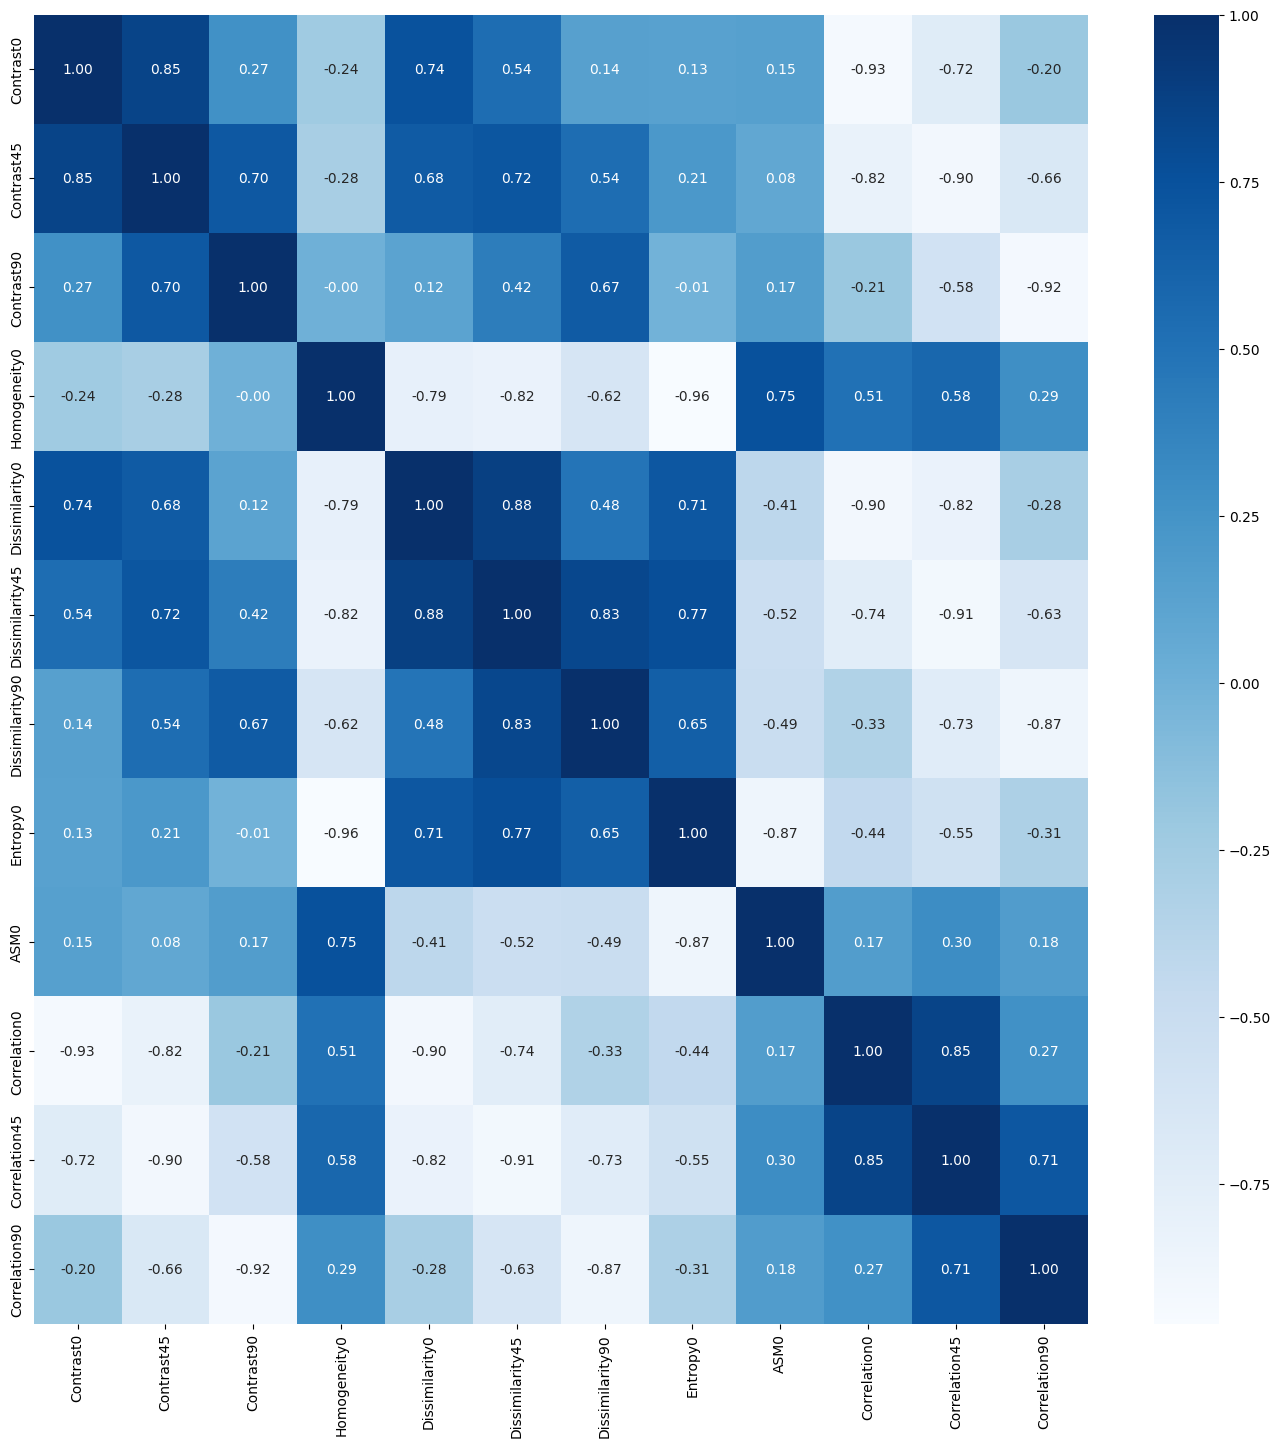

In [29]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

# Splitting Data

 <p align="justify">Pada bagian kode dibawah ini, dilakukan proses pembagian data menjadi data latih (training) dan data uji (testing) menggunakan fungsi train_test_split dari pustaka scikit-learn. Data fitur yang telah diseleksi dan disimpan dalam x_new digunakan sebagai input (variabel X), sedangkan label kelas pada variabel y digunakan sebagai target output. Parameter test_size=0.2 menunjukkan bahwa 20% dari total data akan digunakan sebagai data uji, sementara 80% sisanya akan digunakan untuk melatih model. Opsi random_state=42 ditetapkan agar proses pembagian data bersifat konsisten dan dapat direproduksi—artinya, jika kode dijalankan ulang, pembagian data akan tetap sama. Hasil pembagian disimpan dalam empat variabel: X_train dan y_train untuk data latih, serta X_test dan y_test untuk data uji. Terakhir, ukuran dari data latih dan data uji dicetak dengan print(X_train.shape) dan print(X_test.shape), yang menunjukkan jumlah sampel dan jumlah fitur pada masing-masing subset data. Informasi ini penting untuk memastikan bahwa pembagian data telah sesuai proporsi dan cukup untuk melatih serta menguji model pembelajaran mesin.</p>

In [30]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(940, 12)
(236, 12)


# Feature Normalization

In [31]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

<p align="justify">Di bagian kode diatas ini, dilakukan proses standarisasi data fitur agar setiap kolom memiliki nilai rata-rata nol dan standar deviasi satu. Caranya adalah dengan mengurangi setiap nilai fitur dengan rata-rata fitur tersebut yang dihitung dari data pelatihan (X_train.mean()), kemudian membaginya dengan standar deviasi fitur yang sama dari data pelatihan (X_train.std()). Langkah ini penting karena memastikan bahwa semua fitur berada pada skala yang sama, sehingga model pembelajaran mesin tidak berat sebelah terhadap fitur dengan nilai yang lebih besar atau lebih kecil. Selain itu, proses normalisasi ini juga diterapkan ke data uji (X_test), tetapi menggunakan nilai rata-rata dan standar deviasi yang berasal dari data pelatihan, bukan data uji. Hal ini dilakukan agar model diuji dengan data yang distandarisasi secara konsisten dengan data saat pelatihan, sehingga hasil evaluasi menjadi lebih valid dan reliabel.</p>

# Modeling Define Model

In [32]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

<p align="justify">Kode diatas ini berisi fungsi generateClassificationReport dibuat untuk memudahkan evaluasi performa model klasifikasi dengan menerima dua input utama, yaitu y_true (label asli atau sebenarnya) dan y_pred (label yang diprediksi oleh model). Fungsi ini kemudian mencetak tiga hal penting: laporan klasifikasi lengkap yang menampilkan metrik seperti presisi, recall, dan F1-score untuk setiap kelas, matriks kebingungan (confusion matrix) yang memperlihatkan detail kesalahan klasifikasi, serta akurasi keseluruhan model. Selanjutnya, didefinisikan tiga model klasifikasi yang umum digunakan: RandomForestClassifier dengan 5 pohon keputusan (n_estimators=5) dan pengacakan tetap (random_state=42) untuk memastikan hasil konsisten; SVC dengan kernel radial basis function (rbf), yang efektif untuk menangani data non-linear; serta KNeighborsClassifier dengan jumlah tetangga terdekat sebanyak 5 (n_neighbors=5). Ketiga model ini siap digunakan untuk dilatih dan diuji dalam pipeline klasifikasi, memberikan berbagai pendekatan yang bisa dibandingkan performanya dalam mengklasifikasikan data.</p>

# Train Random Forest Classifier

<p align="justify">evaluasi pada training set, model digunakan untuk memprediksi label dari X_train dengan fungsi .predict(), kemudian hasil prediksi tersebut (y_pred) dibandingkan dengan label sebenarnya (y_train) menggunakan fungsi generateClassificationReport(). Fungsi ini akan mencetak metrik-metrik evaluasi penting seperti presisi, recall, F1-score, akurasi, dan confusion matrix.</p>

<p align="justify">Kemudian, proses yang sama dilakukan untuk testing set. Model memprediksi X_test, lalu hasil prediksinya dibandingkan dengan y_test. Evaluasi terhadap data testing ini penting untuk mengetahui seberapa baik model mampu menggeneralisasi terhadap data baru yang belum pernah dilihat. Dengan membandingkan performa di training dan testing set, pengguna dapat mengidentifikasi apakah model mengalami overfitting (jika akurasi training jauh lebih tinggi dari testing) atau underfitting (jika kedua akurasi sama-sama rendah).</p>

In [33]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

   FreshFish       1.00      0.99      1.00       522
InfectedFish       0.99      1.00      1.00       418

    accuracy                           1.00       940
   macro avg       1.00      1.00      1.00       940
weighted avg       1.00      1.00      1.00       940

[[519   3]
 [  1 417]]
Accuracy: 0.9957446808510638

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       1.00      0.96      0.98       130
InfectedFish       0.95      1.00      0.98       106

    accuracy                           0.98       236
   macro avg       0.98      0.98      0.98       236
weighted avg       0.98      0.98      0.98       236

[[125   5]
 [  0 106]]
Accuracy: 0.9788135593220338


<p align="justify">Hasil evaluasi model Random Forest menunjukkan performa yang sangat baik pada data pelatihan maupun pengujian. Pada training set, model mencapai akurasi hampir sempurna sebesar 99,57%, dengan precision dan recall yang mendekati 1 untuk kedua kelas (FreshFish dan InfectedFish), yang menunjukkan model mampu membedakan kedua kelas dengan sangat akurat tanpa overfitting yang mencolok. Sementara pada testing set, akurasi sedikit menurun menjadi 97,88%, namun tetap tergolong tinggi, dengan f1-score sebesar 0,98 untuk kedua kelas, yang mengindikasikan bahwa model tetap mampu melakukan generalisasi dengan baik. Nilai recall sebesar 1.00 untuk InfectedFish pada testing set juga menunjukkan bahwa model sangat andal dalam mendeteksi kasus ikan yang terinfeksi tanpa ada kesalahan deteksi negatif (false negative).</p>

# Train SVM Classifier

<p align="justify">Pada bagian kode ini, dilakukan pelatihan dan evaluasi model klasifikasi menggunakan algoritma Support Vector Machine (SVM). Model svm, yang sebelumnya telah didefinisikan dengan kernel RBF (Radial Basis Function), dilatih menggunakan data pelatihan X_train dan label-nya y_train melalui metode .fit(). Setelah proses pelatihan selesai, model diuji terlebih dahulu pada data pelatihan untuk melihat sejauh mana model berhasil mempelajari pola dari data yang diberikan.</p>

<p align="justify">Prediksi pada data pelatihan dilakukan dengan svm.predict(X_train), lalu hasil prediksi dibandingkan dengan label sebenarnya (y_train) menggunakan fungsi generateClassificationReport, yang mencetak metrik evaluasi seperti presisi, recall, F1-score, confusion matrix, dan akurasi.</p>

<p align="justify">Setelah itu, model diuji pada data testing X_test untuk mengetahui kemampuan generalisasi model terhadap data baru yang belum pernah dilihat sebelumnya. Prediksi hasil testing (y_pred) dibandingkan dengan label asli (y_test) menggunakan fungsi evaluasi yang sama. Evaluasi ini penting untuk mengetahui apakah model SVM yang telah dilatih hanya cocok dengan data pelatihan (overfitting) atau juga mampu bekerja dengan baik pada data yang lebih umum (generalizable). Dengan membandingkan performa di dua tahap ini, kita bisa menentukan apakah model SVM layak digunakan atau perlu dilakukan tuning lebih lanjut.</p>

In [34]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

   FreshFish       0.89      0.86      0.88       522
InfectedFish       0.84      0.87      0.85       418

    accuracy                           0.87       940
   macro avg       0.86      0.87      0.87       940
weighted avg       0.87      0.87      0.87       940

[[451  71]
 [ 54 364]]
Accuracy: 0.8670212765957447

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.90      0.88      0.89       130
InfectedFish       0.85      0.88      0.87       106

    accuracy                           0.88       236
   macro avg       0.88      0.88      0.88       236
weighted avg       0.88      0.88      0.88       236

[[114  16]
 [ 13  93]]
Accuracy: 0.8771186440677966


<p align="justify">Model SVM menunjukkan performa yang cukup baik dengan akurasi sekitar 86,70% pada data pelatihan dan 87,71% pada data pengujian. Nilai precision, recall, dan f1-score untuk kedua kelas berada di kisaran 0,84 hingga 0,90, yang menunjukkan bahwa model dapat membedakan antara FreshFish dan InfectedFish secara konsisten. Meskipun tidak seakurat model sebelumnya, secara keseluruhan performa model cukup seimbang antara kedua kelas. Performa yang relatif stabil antara data pelatihan dan pengujian juga mengindikasikan bahwa model tidak mengalami overfitting secara signifikan.</p>

# Train KNN Classifier

<p align="justify">Pada bagian kode ini, digunakan algoritma K-Nearest Neighbors (KNN) untuk melakukan pelatihan dan evaluasi model klasifikasi. Model knn, yang sebelumnya didefinisikan dengan n_neighbors=5, dilatih menggunakan data X_train dan y_train melalui fungsi .fit(). KNN bekerja dengan cara mengklasifikasikan data baru berdasarkan mayoritas label dari sejumlah tetangga terdekat (dalam hal ini 5 tetangga) dalam ruang fitur.</p>

<p align="justify">Setelah pelatihan, dilakukan evaluasi terhadap performa model pada data pelatihan. Model memprediksi label dari X_train, dan hasil prediksi dibandingkan dengan label aslinya (y_train) menggunakan fungsi generateClassificationReport. Fungsi ini akan mencetak metrik penting seperti presisi, recall, F1-score, confusion matrix, dan akurasi, untuk menilai seberapa baik model mengenali pola dalam data latih.</p>

<p align="justify">Langkah yang sama dilakukan untuk menguji model pada data testing (X_test) yang belum pernah dilihat oleh model. Hasil prediksi dibandingkan dengan label asli y_test, dan metrik evaluasinya juga dicetak. Evaluasi ini sangat penting untuk mengetahui seberapa baik model KNN mampu melakukan generalisasi terhadap data baru. Jika akurasi pada data training sangat tinggi tetapi rendah pada data testing, maka bisa jadi model terlalu overfit. Namun, jika keduanya seimbang dan tinggi, maka model KNN dapat dianggap baik dalam menangani data klasifikasi yang diberikan.</p>

In [35]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

   FreshFish       0.99      0.98      0.98       522
InfectedFish       0.97      0.98      0.98       418

    accuracy                           0.98       940
   macro avg       0.98      0.98      0.98       940
weighted avg       0.98      0.98      0.98       940

[[511  11]
 [  7 411]]
Accuracy: 0.9808510638297873

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.98      0.98      0.98       130
InfectedFish       0.97      0.97      0.97       106

    accuracy                           0.97       236
   macro avg       0.97      0.97      0.97       236
weighted avg       0.97      0.97      0.97       236

[[127   3]
 [  3 103]]
Accuracy: 0.9745762711864406


<p align="justify">Model K-Nearest Neighbors (KNN) menunjukkan performa yang tinggi dan konsisten pada data pelatihan maupun pengujian, dengan akurasi masing-masing sebesar 98,09% dan 97,46%. Nilai precision, recall, dan f1-score untuk kedua kelas berada di atas 0,97, menandakan bahwa model mampu mengklasifikasikan data secara akurat dan seimbang. Selain itu, perbedaan performa antara data pelatihan dan pengujian tidak terlalu signifikan, yang mengindikasikan bahwa model mampu melakukan generalisasi dengan baik terhadap data baru.</p>

# Evaluation With Confusion Matrix
<p align="justify">Pada bagian kode ini, dibuat sebuah fungsi bernama plot_confusion_matrix yang digunakan untuk menampilkan Confusion Matrix secara visual. Fungsi ini menerima tiga parameter: y_true (label sebenarnya), y_pred (label hasil prediksi model), dan title (judul grafik). Di dalam fungsi, pertama-tama dihitung confusion matrix menggunakan confusion_matrix dari sklearn, lalu ditampilkan secara visual melalui ConfusionMatrixDisplay. Warna latar belakang matriks diatur menggunakan colormap biru (plt.cm.Blues) agar lebih mudah dibaca, dan judul grafik ditampilkan sesuai parameter yang diberikan. Fungsi plt.show() digunakan untuk menampilkan hasil plot ke layar.</p>

<p align="justify">Selanjutnya, fungsi ini dipanggil tiga kali, masing-masing untuk menampilkan confusion matrix dari hasil prediksi tiga model berbeda: Random Forest, SVM, dan KNN, semuanya terhadap data testing (y_test). Visualisasi confusion matrix ini sangat berguna untuk memahami secara lebih jelas pola kesalahan model dalam mengklasifikasikan data—misalnya, seberapa banyak sampel dari satu kelas yang diklasifikasikan secara keliru menjadi kelas lain. Ini membantu analisis performa model secara lebih mendalam dibandingkan hanya melihat akurasi.</p>

In [40]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()


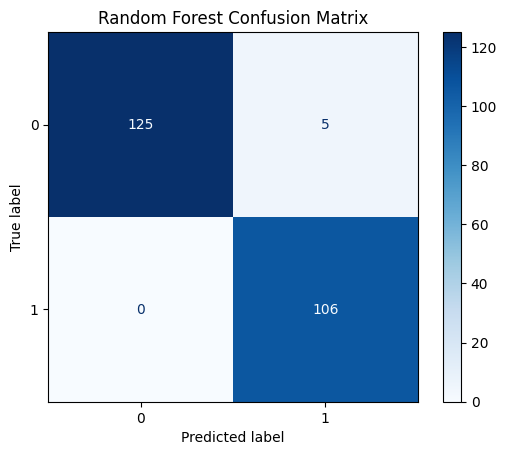

In [37]:
# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")

<p align="justify">Confusion matrix menunjukkan bahwa dari 130 sampel FreshFish (label 0), sebanyak 125 berhasil diklasifikasikan dengan benar, sementara 5 sisanya diklasifikasikan sebagai InfectedFish (label 1), yang berarti ada tingkat false positive sekitar 3,85%. Ini menunjukkan bahwa model cenderung sedikit over-sensitive terhadap fitur yang diasosiasikan dengan kelas InfectedFish, sehingga beberapa sampel FreshFish dianggap memiliki karakteristik yang mirip dengan ikan terinfeksi. Sebaliknya, tidak ditemukan kasus false negative (0 kasus), artinya model sangat yakin ketika mendeteksi kelas InfectedFish. Hal ini bisa menunjukkan bahwa fitur pada kelas InfectedFish memiliki pola yang lebih konsisten atau lebih menonjol dibandingkan FreshFish, sehingga lebih mudah dikenali oleh model.</p>

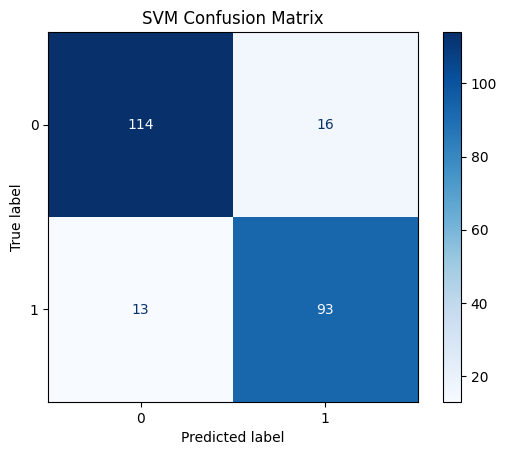

In [38]:
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")

<p align="justify">Confusion matrix hasil model SVM menunjukkan  sebanyak 114 berhasil diklasifikasikan dengan benar, sementara 16 sisanya dikategorikan sebagai kelas positif, menghasilkan tingkat false positive sekitar 12,31%. Ini menunjukkan bahwa model memiliki kecenderungan sedikit over-sensitive terhadap fitur yang diasosiasikan dengan kelas positif, sehingga beberapa sampel kelas negatif dianggap memiliki karakteristik serupa dengan kelas positif. Sebaliknya, pada sampel kelas positif, sebanyak 93 berhasil diklasifikasikan dengan benar, sementara 13 kasus dikategorikan sebagai kelas negatif, menunjukkan tingkat false negative 12,26%.</p>

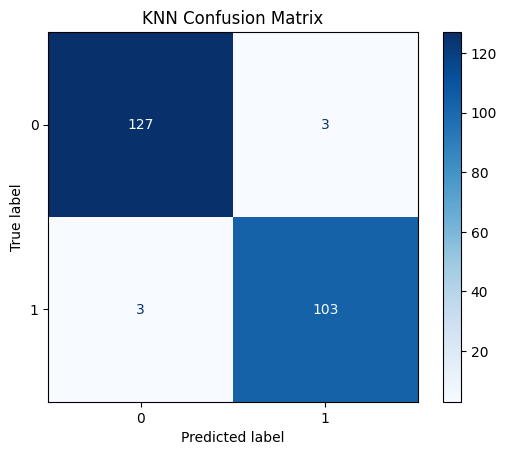

In [39]:
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")

<p align="justify">Confusion matrix hasil model KNN menunjukkan bahwa sebanyak 103 sampel kelas positif berhasil diklasifikasikan dengan benar, sementara 3 sampel kelas negatif dikategorikan sebagai kelas positif, menghasilkan tingkat false positive sekitar 2,83%. Hal ini menunjukkan bahwa model memiliki kecenderungan yang cukup akurat dalam mengenali karakteristik kelas negatif tanpa terlalu banyak kesalahan. Sebaliknya, pada sampel kelas positif, sebanyak 127 berhasil diklasifikasikan dengan benar, sementara 3 kasus dikategorikan sebagai kelas negatif, menunjukkan tingkat false negative sebesar 2,78%.</p>